In [20]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import jenkspy
import json
import os.path

In [21]:
THRESHOLD = 800

In [22]:
def plot(x, y, opts):
    fig, ax = plt.subplots()
    ax.plot(x, y)
    plt.xscale('log', base=2)
    plt.grid()
    plt.xlabel(opts['x'])
    plt.ylabel(opts['y'])
    plt.title(opts['title'])

In [23]:
# load database
with open('./raga.json') as db:
    database = json.load(db)

# read audio file
file = input('Enter file name: ')
if(not(os.path.exists(f'./audio/wav/{file}.wav'))):
    raise FileExistsError('File not found!')
samples, fs = librosa.load(f'./audio/wav/{file}.wav', sr=None)

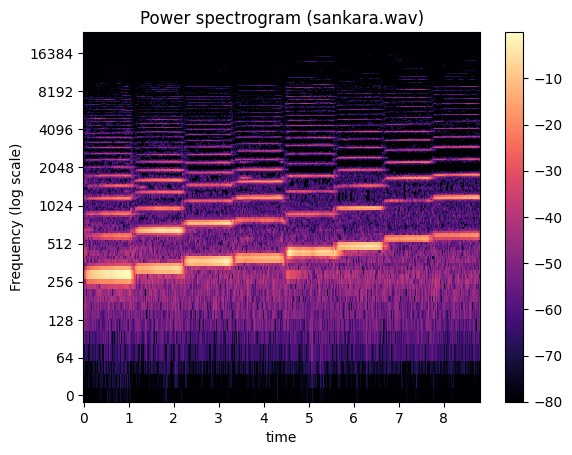

In [24]:
D = librosa.stft(samples)
S = np.abs(D)
S_db = librosa.amplitude_to_db(S, ref=np.max)

plt.figure()
librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=fs)
plt.colorbar()
plt.title(f'Power spectrogram ({file}.wav)')
plt.xlabel('time')
plt.ylabel('Frequency (log scale)')
plt.show(block=False)

In [25]:
CLUSTER_SIZE = int(input('Enter the count of unique frequencies visible: '))
BAND_PASS_FL = int(input('Enter frequency of madhyama sthayi Sa: '))
BAND_PASS_FH = 2*BAND_PASS_FL

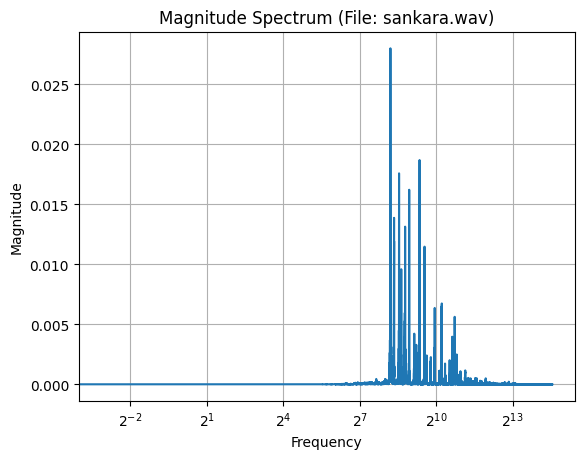

In [26]:
# generate array of frequencies
n = len(samples)
xf = np.linspace(0, int(fs/2), int(n/2))

# compute fft
yf = np.fft.fft(samples)

# plot spectrum before filtering
plot(xf, 2/n*np.abs(yf[:n//2]), {
    'x': 'Frequency',
    'y': 'Magnitude',
    'title': f'Magnitude Spectrum (File: {file}.wav)'
})

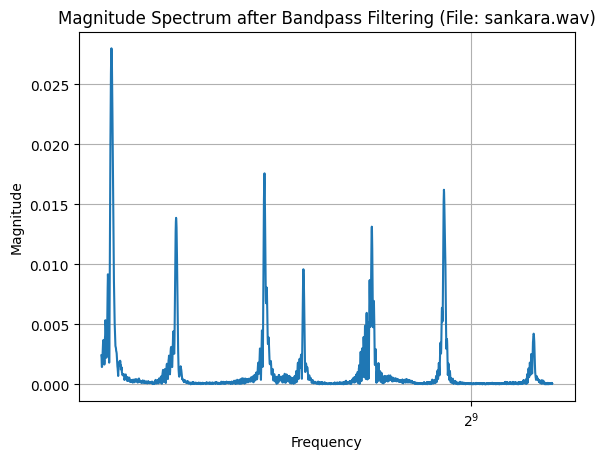

In [27]:
# bandpass filter
indices = np.where((xf > BAND_PASS_FL) & (xf < BAND_PASS_FH))
xf = np.take(xf, indices)[0]
yf = np.take(yf, indices)[0]

# plot spectrum after bandpass filtering
plot(xf, 2/n*np.abs(yf[:n//2]), {
    'x': 'Frequency',
    'y': 'Magnitude',
    'title': f'Magnitude Spectrum after Bandpass Filtering (File: {file}.wav)'
})

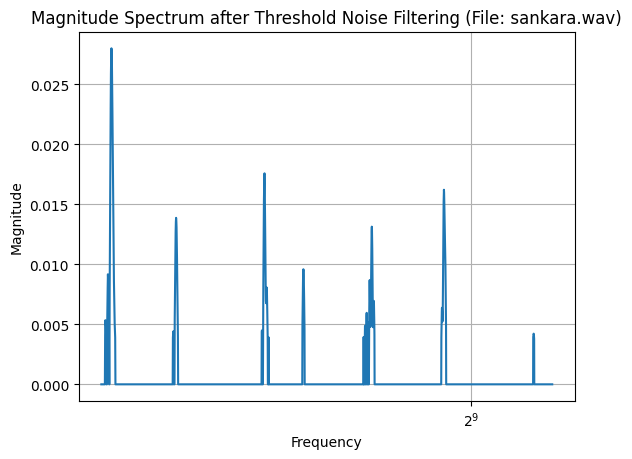

In [28]:
# zero out amplitudes below threshold
yf = np.where(abs(yf) < THRESHOLD, 0, yf)

# zero out frequencies corresponding to amplitudes below threshold
freqs = np.copy(xf)
for i in range(len(freqs)):
    if(abs(yf[i]) < THRESHOLD):
        freqs[i] = 0

# filter out zeros
amps = np.copy(yf)
freqs = np.array(list(filter(lambda f: (f != 0), freqs)))
amps = np.array(list(filter(lambda a: (a != 0), amps)))

# plot spectrum after threshold noise filtering
plot(xf, 2/n*np.abs(yf[:n//2]), {
    'x': 'Frequency',
    'y': 'Magnitude',
    'title': f'Magnitude Spectrum after Threshold Noise Filtering (File: {file}.wav)'
})

In [29]:
# split frequencies into clusters
clusters = jenkspy.jenks_breaks(freqs, n_classes=CLUSTER_SIZE)
cluster_idx = np.array(
    list(map(lambda bound: (np.where(freqs == bound)[0][0]), clusters))
)
print('Cluster bounding frequencies:', clusters)

Cluster bounding frequencies: [291.7094449780234, 296.2514371146995, 326.22858521676187, 375.05500068603004, 396.2888139249909, 441.2545360780844, 492.5790472225245, 564.0018735717564]


In [30]:
# find peaks
peakFreqs = []
for i in range(len(cluster_idx)-1):
    start = cluster_idx[i] if(i == 0) else cluster_idx[i]+1
    stop = cluster_idx[i+1]+1
    peak = freqs[np.where(abs(amps) == max(abs(amps[start:stop])))[0][0]]
    peakFreqs.append(peak)

print('Peak Frequencies:', peakFreqs)

# normalize peaks
normPeakFreqs = [freq/min(peakFreqs) for freq in peakFreqs]
print('Normalized Peak Frequencies:', normPeakFreqs)

Peak Frequencies: [294.54819006344593, 325.3201867894266, 372.6704548142751, 395.6075151044895, 439.437739223414, 490.98934997468785, 563.5476743580888]
Normalized Peak Frequencies: [1.0, 1.1044718581341557, 1.2652274479568235, 1.343099460292984, 1.491904394757132, 1.6669236700077101, 1.9132613723978413]


In [31]:
# compute euclidean distance
dists = []
for entry in database:
    trueRatios = np.array(entry['ratios'])
    computedRatios = np.array(normPeakFreqs)
    maxLen = max(len(trueRatios), len(computedRatios))
    trueRatios = np.pad(trueRatios, (0, maxLen - len(trueRatios)))
    computedRatios = np.pad(computedRatios, (0, maxLen - len(computedRatios)))
    dist = np.linalg.norm(computedRatios - trueRatios)
    dists.append(dist)

In [32]:
# predict raaga using index of minDist
minDist = min(dists)
minDistIdx = dists.index(minDist)
print('The raaga is:', database[minDistIdx]['raaga'])
print('Euclidean distance:', minDist)

The raaga is: sankarabharanam
Euclidean distance: 0.04779912286050789


In [33]:
# compute confidence %
trueRatios = database[minDistIdx]['ratios']
mean_t = np.mean(trueRatios)
var_t = np.var(trueRatios)
mean_c = np.mean(normPeakFreqs)
var_c = np.var(normPeakFreqs)
d = len(trueRatios)
maxDist = np.sqrt(d*((mean_c - mean_t)**2 + (var_c + var_t)**2))
error = (minDist/maxDist) * 100
print(f'Confidence = {100 - error}%')

Confidence = 89.29648132164361%
